In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
# print(plt.style.available)
plt.style.use("ggplot")
# plt.style.use("fivethirtyeight")
plt.style.use("seaborn-talk")

from tqdm import tnrange, tqdm_notebook

In [2]:
def uniform_linear_array(n_mics, spacing):
    return spacing*np.arange(-(n_mics-1)/2, (n_mics-1)/2+1).reshape(1, n_mics)

def compute_MVDR_weight(source_steering_vector, signals):
    snapshot = signals.shape[1]
    sample_covariance_matrix = signals.dot(signals.transpose().conjugate()) / snapshot
    inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
    normalization_factor = (source_steering_vector.transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(source_steering_vector))
    weight = inverse_sample_covariance_matrix.dot(source_steering_vector) / normalization_factor
    return weight

def compute_steering_vector_ULA(u, microphone_array):
    return np.exp(1j*2*np.pi*microphone_array.geometry*u).reshape((microphone_array.n_mics, 1))

def generate_gaussian_samples(power, shape):
    return np.sqrt(power/2)*np.random.randn(shape[0], shape[1]) + 1j*np.sqrt(power/2)*np.random.randn(shape[0], shape[1]); # signal samples

class MicrophoneArray():
    def __init__(self, array_geometry):
        self.dim = array_geometry.shape[0]
        self.n_mics = array_geometry.shape[1]
        self.geometry = array_geometry

    
        
class BaseDLBeamformer(object):
    def __init__(self, vs, bf_type="MVDR"):
        """
        Parameters
        ----------
        vs: Source manifold array vector
        bf_type: Type of beamformer
        """
        self.vs = vs
        self.bf_type = bf_type
        self.weights_ = None
        
    def _compute_weights(self, training_data):
        n_training_samples = len(training_data)
        n_mics, snapshot = training_data[0].shape
        D = np.zeros((n_mics, n_training_samples), dtype=complex)
        for i_training_sample in range(n_training_samples):
            nv = training_data[i_training_sample]
            if self.bf_type == "MVDR":
                w = compute_MVDR_weight(vs, nv)
            D[:, i_training_sample] = w.reshape(n_mics,)
        return D

    def _initialize(self, X):
        pass

    def _choose_weights(self, x):
        n_dictionary_atoms = self.weights_.shape[1]
        R = x.dot(x.transpose().conjugate())
        proxy = np.diagonal(self.weights_.transpose().conjugate().dot(R).dot(self.weights_))
        optimal_weight_index = np.argmin(proxy)
        return self.weights_[:, optimal_weight_index]
    
    def fit(self, training_data):
        """
        Parameters
        ----------
        X: shape = [n_samples, n_features]
        """
        D = self._compute_weights(training_data)
        self.weights_ = D
        return self

    def choose_weights(self, x):
        return self._choose_weights(x)

#### Setup

In [3]:
array_geometry = uniform_linear_array(n_mics=10, spacing=0.5)
microphone_array = MicrophoneArray(array_geometry)
us = 0
vs = compute_steering_vector_ULA(us, microphone_array)
SNRs = np.arange(0, 31, 10)
n_SNRs = len(SNRs)
sigma_n = 1

#### Training data

In [4]:
n_training_samples = 5000
training_snapshots = [10, 50, 1000]
interference_powers = [10, 20, 30]
n_interference_list = [1, 2, 3]
# interference_powers = [20]
# n_interference_list = [1]
# sigma = 10**(20/10)
training_noise_interference_data_various_snapshots = []
for training_snapshot in training_snapshots:
    training_noise_interference_data = []
    for i_training_sample in range(n_training_samples):        
        n_interferences = np.random.choice(n_interference_list)
        nv = np.zeros((microphone_array.n_mics, training_snapshot), dtype=complex)
        for _ in range(n_interferences):
            u = np.random.uniform(0, 1)
            vi = compute_steering_vector_ULA(u, microphone_array)
            sigma = 10**(np.random.choice(interference_powers)/10)
            ii = generate_gaussian_samples(power=sigma, shape=(1, training_snapshot))
            nv += vi.dot(ii)
        noise = generate_gaussian_samples(power=sigma_n, shape=(microphone_array.n_mics, training_snapshot))
        nv += noise
        training_noise_interference_data.append(nv)
    training_noise_interference_data_various_snapshots.append(training_noise_interference_data)

#### Train baseline dictionary

In [5]:
dictionaries = []
for i_training_snapshot in range(len(training_snapshots)):
    training_noise_interference_data = training_noise_interference_data_various_snapshots[i_training_snapshot]
    dictionary = BaseDLBeamformer(vs)
    dictionary.fit(training_noise_interference_data);
    dictionaries.append(dictionary)

#### Testing

In [ ]:
n_trials = 200
snapshots = np.array([10, 20, 30, 40, 60, 100, 200, 500, 1000])
n_snapshots = len(snapshots)
ui1 = np.random.uniform(0, 1)
ui2 = np.random.uniform(0, 1)
sigma_1 = 10**(20/10)
sigma_2 = 0*10**(20/10)
vi1 = compute_steering_vector_ULA(ui1, microphone_array)
vi2 = compute_steering_vector_ULA(ui2, microphone_array)

n_interferences = np.random.choice(n_interference_list)
interference_steering_vectors = []
for _ in range(n_interferences):
    u = np.random.uniform(0, 1)
    vi = compute_steering_vector_ULA(u, microphone_array)
    interference_steering_vectors.append(vi)    




sinr_snr_mvdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_mpdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_baseline_mpdr = np.zeros((len(training_snapshots), n_SNRs, n_snapshots))

for i_SNR in tqdm_notebook(range(n_SNRs), desc="SNRs"):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())    
    
    for i_snapshot in tqdm_notebook(range(n_snapshots), desc="Snapshots", leave=False):
        snapshot = snapshots[i_snapshot]
        sinr_mvdr = np.zeros(n_trials)
        sinr_mpdr = np.zeros(n_trials)
        sinr_baseline_mpdr = np.zeros((len(training_snapshots), n_trials))
        
        for i_trial in range(n_trials):
            
            ss = generate_gaussian_samples(power=sigma_s, shape=(1, snapshot)) # signal samples
            nn = generate_gaussian_samples(power=sigma_n, shape=(microphone_array.n_mics, snapshot)) # Gaussian noise samples
#             ii1 = generate_gaussian_samples(power=sigma_1, shape=(1, snapshot)) # first interference samples
#             ii2 = generate_gaussian_samples(power=sigma_2, shape=(1, snapshot)) # second interference samples
            nv = np.zeros((microphone_array.n_mics, snapshot), dtype=complex)
            Rn = np.zeros((microphone_array.n_mics, microphone_array.n_mics), dtype=complex)
            for i_interference in range(n_interferences):
                sigma = 10**(np.random.choice(interference_powers)/10)
                ii = generate_gaussian_samples(power=sigma, shape=(1, snapshot))
                nv += interference_steering_vectors[i_interference].dot(ii)
                Rn += sigma*interference_steering_vectors[i_interference].dot(interference_steering_vectors[i_interference].transpose().conjugate())
            Rn += sigma_n*np.identity(microphone_array.n_mics)
            Rninv = np.linalg.inv(Rn)
            Wo = Rninv.dot(vs) / (vs.transpose().conjugate().dot(Rninv).dot(vs))
            SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
            
            nv += nn
            sv = vs.dot(ss)
            xx = sv + nv
            
            wv = compute_MVDR_weight(vs, nv)
            wp = compute_MVDR_weight(vs, xx)
            
            for i_dictionary in range(len(dictionaries)):
                dictionary = dictionaries[i_dictionary]
                w_baseline_p = dictionary.choose_weights(xx)
                sinr_baseline_mpdr[i_dictionary, i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p))
                
            sinr_mvdr[i_trial] = np.real(wv.transpose().conjugate().dot(Rs).dot(wv)) / np.real(wv.transpose().conjugate().dot(Rn).dot(wv))
            sinr_mpdr[i_trial] = np.real(wp.transpose().conjugate().dot(Rs).dot(wp)) / np.real(wp.transpose().conjugate().dot(Rn).dot(wp))
            
        sinr_snr_mvdr[i_SNR, i_snapshot] = np.sum(sinr_mvdr) / n_trials
        sinr_snr_mpdr[i_SNR, i_snapshot] = np.sum(sinr_mpdr) / n_trials
        for i_dictionary in range(len(dictionaries)):
            sinr_snr_baseline_mpdr[i_dictionary, i_SNR, i_snapshot] = np.sum(sinr_baseline_mpdr[i_dictionary, :]) / n_trials

#### Visualize results

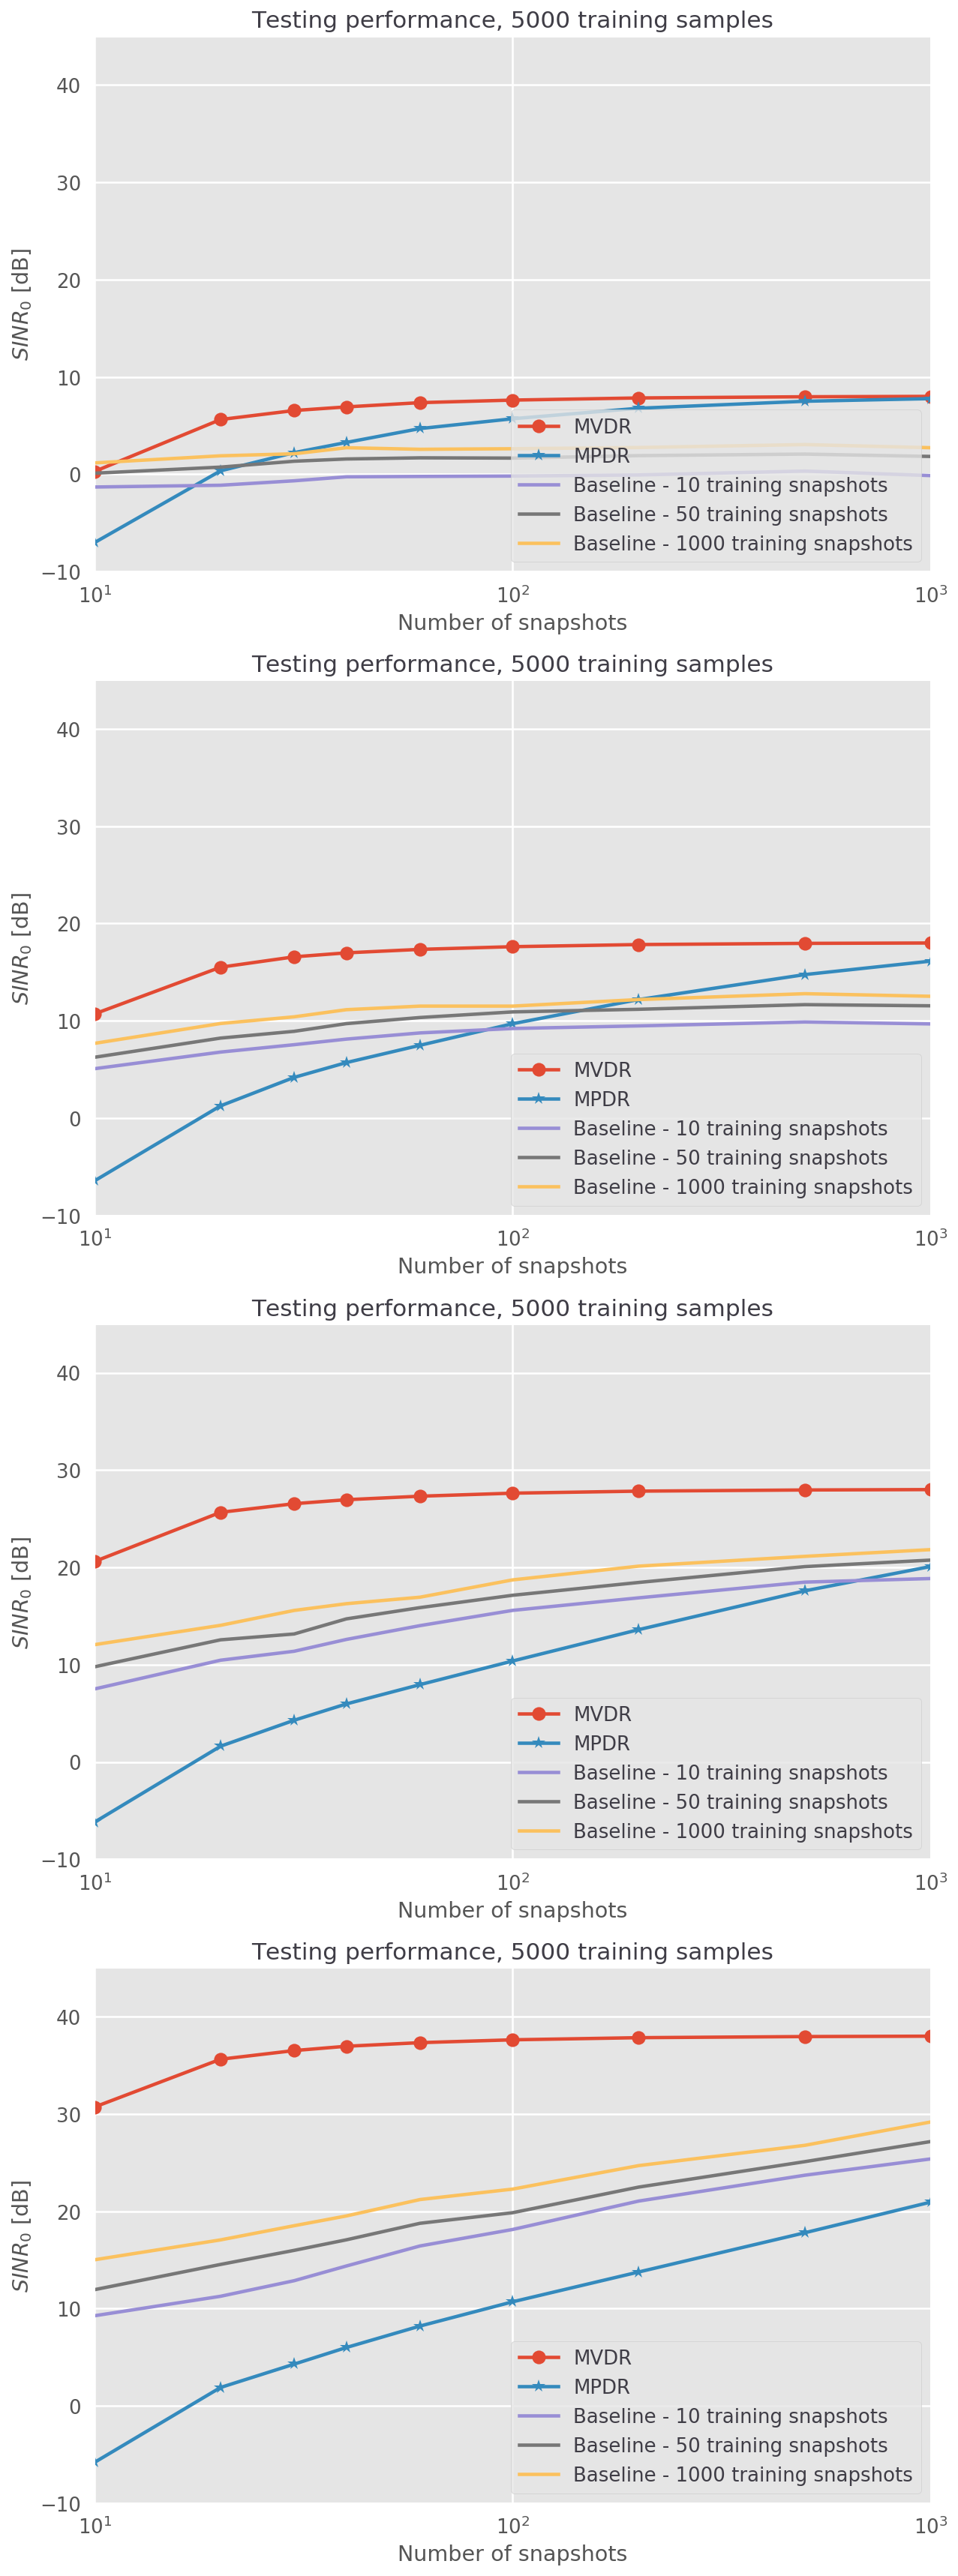

In [8]:
fig = plt.figure(figsize=(9, 6*n_SNRs)); 
for i_SNR in range(n_SNRs):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
    SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
    ax = fig.add_subplot(n_SNRs, 1, i_SNR+1)
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, :]), marker="o", label="MVDR")
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, :]), marker="*", label="MPDR")
    for i_training_snapshot in range(len(training_snapshots)):
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, :]), 
                    label="Baseline - {} training snapshots".format(training_snapshots[i_training_snapshot]))
    ax.set_xlim(10, 1000); ax.set_ylim(-10, 45)
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of snapshots")
    ax.set_ylabel(r"$SINR_0$ [dB]")
    ax.set_title("Testing performance, {} training samples".format(n_training_samples))
plt.tight_layout()
fig.savefig("baseline_dl_mvdr_various_interferences.jpg", dpi=600)